In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import notebook
from torch.utils.data import DataLoader, TensorDataset
from src.utils import calculate_signature_matrix_dataset, generate_dataset
from src.mscred import MSCRED
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# all_data = generate_dataset(n_features=30, seq_len=30000)

In [6]:
# np.save('data/generated_dataset.npy', all_data.astype('float32'))

In [7]:
all_data = np.load('data/generated_dataset.npy')

In [8]:
train_data = all_data[:-3000]
test_data = all_data[-3000:]

Example plot of 10 first timeseries

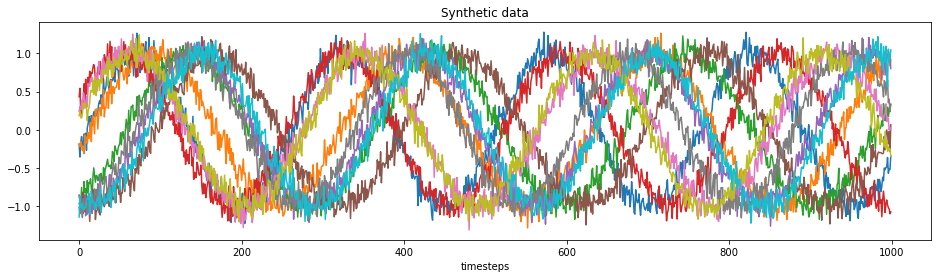

In [20]:
plt.figure(figsize=(16,4))
plt.plot(all_data[:1000,:10])
plt.title('Synthetic data')
plt.xlabel('timesteps')
plt.show()

In [13]:
def create_anomaly(data, start_index=100,  duration=60, series_num=0):
    base_value = data[start_index, series_num]
    data[start_index:start_index + duration, series_num] = base_value + np.random.normal(loc=0, scale=0.8, size=duration)

Creating anomalies with different durations

In [14]:
create_anomaly(test_data,  start_index=300,  duration=90, series_num=0)
create_anomaly(test_data,  start_index=2300,  duration=60, series_num=0)
create_anomaly(test_data,  start_index=1200,  duration=60, series_num=16)
create_anomaly(test_data,  start_index=2000,  duration=30, series_num=19)

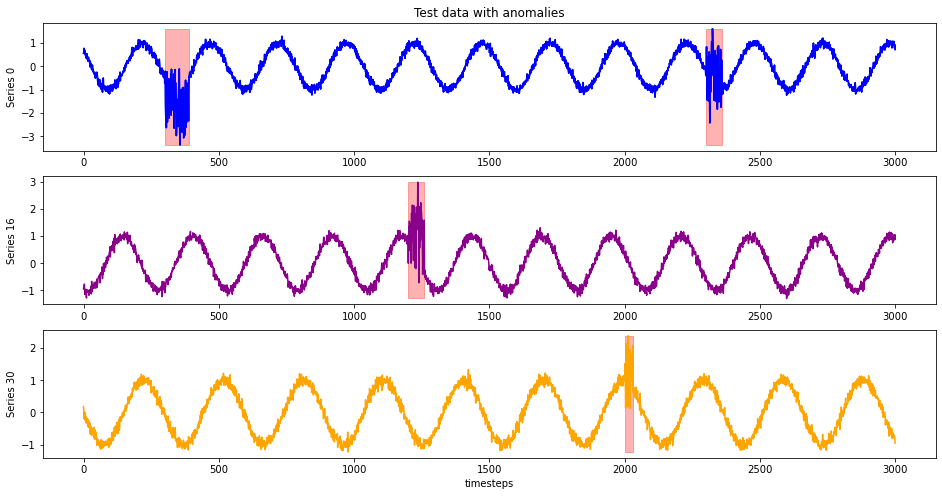

In [19]:
fig, ax = plt.subplots(3,1, figsize=(16,8))
ax[0].set_title('Test data with anomalies')
ax[0].plot(test_data[:,0], color='blue')
ax[0].fill_between(np.arange(300,300+90), y1=min(test_data[:,0]), y2=max(test_data[:,0]), color='red', alpha=0.3)
ax[0].plot(test_data[:,0], color='blue')
ax[0].set_ylabel('Series 0')
ax[0].fill_between(np.arange(2300,2300+60), y1=min(test_data[:,0]), y2=max(test_data[:,0]), color='red', alpha=0.3)
ax[1].plot(test_data[:,16], color='darkmagenta')
ax[1].fill_between(np.arange(1200,1200+60), y1=min(test_data[:,16]), y2=max(test_data[:,16]), color='red', alpha=0.3)
ax[1].set_ylabel('Series 16')
ax[2].plot(test_data[:,19], color='orange')
ax[2].fill_between(np.arange(2000,2000+30), y1=min(test_data[:,19]), y2=max(test_data[:,19]), color='red', alpha=0.3)
ax[2].set_ylabel('Series 30')
ax[2].set_xlabel('timesteps')
plt.show()

In [21]:
X, y = calculate_signature_matrix_dataset(train_data, lags=[10, 30, 60], stride=1, num_timesteps=5)

100%|███████████████████████████████████████████████████████████████████████████| 26941/26941 [02:53<00:00, 155.30it/s]


In [22]:
X = X.transpose(0, 4, 1, 2, 3)

In [23]:
y = y.transpose(0,3,1,2)

In [24]:
X.shape

(26937, 3, 5, 30, 30)

In [25]:
y.shape

(26937, 3, 30, 30)

Plot layers of generated target signature matrix for fun

In [27]:
test_matrix = y[0]

In [28]:
test_matrix.shape

(3, 30, 30)

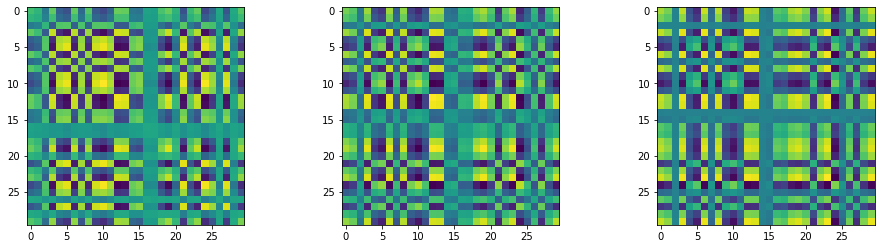

In [31]:
fig, ax = plt.subplots(1,3, figsize=(16,4))
ax[0].imshow(test_matrix[0,:,:])
ax[1].imshow(test_matrix[1,:,:])
ax[2].imshow(test_matrix[2,:,:])

In [32]:
train_size = int(0.7*len(X))

In [33]:
X_train = torch.Tensor(X[:train_size])
y_train = torch.Tensor(y[:train_size])
X_val = torch.Tensor(X[train_size:])
y_val = torch.Tensor(y[train_size:])

In [34]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=128, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=128, shuffle=False)

In [36]:
model = MSCRED(num_timesteps=5, attention=True).cuda()

In [37]:
model.train()

MSCRED(
  (Conv1): Conv3d(3, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
  (ConvLSTM1): ConvLSTM(
    (flatten): Flatten()
  )
  (Conv2): Conv3d(32, 64, kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
  (ConvLSTM2): ConvLSTM(
    (flatten): Flatten()
  )
  (Conv3): Conv3d(64, 128, kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=(0, 1, 1))
  (ConvLSTM3): ConvLSTM(
    (flatten): Flatten()
  )
  (Conv4): Conv3d(128, 256, kernel_size=(1, 2, 2), stride=(1, 2, 2))
  (ConvLSTM4): ConvLSTM(
    (flatten): Flatten()
  )
  (Deconv4): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (Deconv3): ConvTranspose2d(256, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  (Deconv2): ConvTranspose2d(128, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (Deconv1): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [38]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [39]:
scheduler = optim.lr_scheduler.StepLR(optimizer, 10, 0.8)

In [40]:
criterion = nn.MSELoss()

In [41]:
early_stop_rounds = 10
j = 0
best_loss = 1e10
epoch = 0
train_losses = []
val_losses = []
while j < early_stop_rounds:
    train_loss = 0.
    val_loss = 0.
    for batch_x, batch_y in notebook.tqdm(train_loader):
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            val_loss += loss.item()
            
        if val_loss < best_loss:
            best_loss = val_loss
            j = 0
            torch.save(model.state_dict(), 'weights/mscred_weights.pt')
        else:
            j+=1
    print('epoch: {} train loss: {}, validation loss:{}'.format(epoch, train_loss/len(train_loader),
                                                                val_loss/len(val_loader)))
    epoch += 1
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    scheduler.step()
        


epoch: 0 train loss: 0.027096336757814563, validation loss:0.006750598615326453



epoch: 1 train loss: 0.003104432492290397, validation loss:0.004375749125756556



epoch: 2 train loss: 0.0019063654464254206, validation loss:0.0035465386317810044



epoch: 3 train loss: 0.0014277011764902822, validation loss:0.0031470614922000095



epoch: 4 train loss: 0.0011657748868487575, validation loss:0.0027611050336417975



epoch: 5 train loss: 0.000997987375248576, validation loss:0.002537274407586665



epoch: 6 train loss: 0.0008773921927550455, validation loss:0.0023965123655216303



epoch: 7 train loss: 0.0007978217150053211, validation loss:0.0022881941931700567



epoch: 8 train loss: 0.0007306274350707394, validation loss:0.002130163262336282



epoch: 9 train loss: 0.0006782321264885517, validation loss:0.0020349667211121414



epoch: 10 train loss: 0.0006135841686045751, validation loss:0.0019512660537657212



epoch: 11 train loss: 0.0005817236732754454, validation loss:0.0018970432811329374



epoch: 12 train loss: 0.0005574245969418789, validation loss:0.0018517261214583414



epoch: 13 train loss: 0.0005313571455189958, validation loss:0.0018488133646314964



epoch: 14 train loss: 0.0005071509104045863, validation loss:0.001729135157802375



epoch: 15 train loss: 0.00048167494419062306, validation loss:0.0016953383019426838



epoch: 16 train loss: 0.00046012183038574467, validation loss:0.0016271291869998095



epoch: 17 train loss: 0.0004336128954860583, validation loss:0.0015768002413096838



epoch: 18 train loss: 0.00041759090625517373, validation loss:0.0015241589426295832



epoch: 19 train loss: 0.0003968693207433397, validation loss:0.0014789935548833455



epoch: 20 train loss: 0.00036276160401915123, validation loss:0.0014385946160473395



epoch: 21 train loss: 0.0003530657702720271, validation loss:0.001418131261743838



epoch: 22 train loss: 0.0003446825625409523, validation loss:0.0013878140052838717



epoch: 23 train loss: 0.00033292301963523934, validation loss:0.001342750985713792



epoch: 24 train loss: 0.0003227999591586381, validation loss:0.001322571862147015



epoch: 25 train loss: 0.000316876132863989, validation loss:0.0012814212668672553



epoch: 26 train loss: 0.0003046269905737702, validation loss:0.0012505464201240102



epoch: 27 train loss: 0.0002946650978678057, validation loss:0.001234667001881462



epoch: 28 train loss: 0.0002840454377488837, validation loss:0.0011905718788511876



epoch: 29 train loss: 0.00027973491779522265, validation loss:0.001162874906185607



epoch: 30 train loss: 0.0002578266403115531, validation loss:0.0011356680538483488



epoch: 31 train loss: 0.00025369757841454466, validation loss:0.0011214932510483777



epoch: 32 train loss: 0.0002506265078114371, validation loss:0.0011023666315850278



epoch: 33 train loss: 0.00024746922497650157, validation loss:0.0010848198585335922



epoch: 34 train loss: 0.00024204141772242037, validation loss:0.0010641146877787833



epoch: 35 train loss: 0.00023777113017638693, validation loss:0.0010395409271950484



epoch: 36 train loss: 0.00023202903085385097, validation loss:0.0010330339582651504



epoch: 37 train loss: 0.00022910337940777173, validation loss:0.0010290855752828065



epoch: 38 train loss: 0.0002249524751843293, validation loss:0.0010482845000296948



epoch: 39 train loss: 0.00022026050400863578, validation loss:0.000979828901563451



epoch: 40 train loss: 0.00020647399513699065, validation loss:0.0009617017276468687



epoch: 41 train loss: 0.00020413857389546655, validation loss:0.000951642515246931



epoch: 42 train loss: 0.00020236095578356244, validation loss:0.0009394624294145615



epoch: 43 train loss: 0.00020112275897927985, validation loss:0.0009231659200850117



epoch: 44 train loss: 0.0001990894136700238, validation loss:0.0009162949636447593



epoch: 45 train loss: 0.00019582859110684963, validation loss:0.0009059951635208563



epoch: 46 train loss: 0.00019300983252390792, validation loss:0.0008987414416878892



epoch: 47 train loss: 0.00019177581133270587, validation loss:0.0008901448263713974



epoch: 48 train loss: 0.00018726560636030235, validation loss:0.0008653027243781253



epoch: 49 train loss: 0.0001849618913822908, validation loss:0.0008592734952799219



epoch: 50 train loss: 0.00017643538405929968, validation loss:0.0008480428482471325



epoch: 51 train loss: 0.00017469700970970144, validation loss:0.0008430995112576056



epoch: 52 train loss: 0.0001740741367079003, validation loss:0.0008388962532990263



epoch: 53 train loss: 0.0001736600867376625, validation loss:0.0008353703733519069



epoch: 54 train loss: 0.000172138301226172, validation loss:0.0008226110699069977



epoch: 55 train loss: 0.0001702489338443942, validation loss:0.0008155729624377273



epoch: 56 train loss: 0.0001675506588268232, validation loss:0.0008028112474676163



epoch: 57 train loss: 0.00016655285120627063, validation loss:0.0008009276893972128



epoch: 58 train loss: 0.0001655129007475979, validation loss:0.000787318027960282



epoch: 59 train loss: 0.0001625427374509289, validation loss:0.0007801593601470813



epoch: 60 train loss: 0.00015670530528704812, validation loss:0.0007718139022472315



epoch: 61 train loss: 0.000155999229251835, validation loss:0.0007681315628360608



epoch: 62 train loss: 0.00015538522603566053, validation loss:0.0007660175183445972



epoch: 63 train loss: 0.00015422474924078514, validation loss:0.000759436691623705



epoch: 64 train loss: 0.00015365519396476197, validation loss:0.0007544201157543284



epoch: 65 train loss: 0.00015295874716783245, validation loss:0.0007513748587371083



epoch: 66 train loss: 0.00015096060766105389, validation loss:0.0007389581314782845



epoch: 67 train loss: 0.00015030015099516794, validation loss:0.0007371772321675962



epoch: 68 train loss: 0.00014892123225443947, validation loss:0.0007323968789023638



epoch: 69 train loss: 0.00014767062482958963, validation loss:0.0007233732521854108



epoch: 70 train loss: 0.00014353184313812244, validation loss:0.000718534441148222



epoch: 71 train loss: 0.00014253515070555982, validation loss:0.0007138785804272629



epoch: 72 train loss: 0.0001419501715792796, validation loss:0.0007123981604308938



epoch: 73 train loss: 0.00014169260287638503, validation loss:0.0007103113030098029



epoch: 74 train loss: 0.00014123508554877008, validation loss:0.0007032836447251611



epoch: 75 train loss: 0.00013985245616798215, validation loss:0.0007021968935987388



epoch: 76 train loss: 0.0001392401017427973, validation loss:0.0006942638974578585



epoch: 77 train loss: 0.0001383805859871712, validation loss:0.0006920375481058727



epoch: 78 train loss: 0.00013722968032124226, validation loss:0.0006891633609029668



epoch: 79 train loss: 0.00013661002457091535, validation loss:0.0006846169237633148



epoch: 80 train loss: 0.00013371174193437313, validation loss:0.0006789953565657925



epoch: 81 train loss: 0.00013313587397852962, validation loss:0.0006764309227946796



epoch: 82 train loss: 0.00013248621286726807, validation loss:0.0006733092818649311



epoch: 83 train loss: 0.00013214278983100116, validation loss:0.0006712678321036947



epoch: 84 train loss: 0.000131257941354085, validation loss:0.0006675142362837505



epoch: 85 train loss: 0.0001309821652555272, validation loss:0.0006642143027875136



epoch: 86 train loss: 0.0001303804539831519, validation loss:0.000660255020875411



epoch: 87 train loss: 0.00012941798942503393, validation loss:0.0006576723471880541



epoch: 88 train loss: 0.0001292160408952072, validation loss:0.0006589363590592257



epoch: 89 train loss: 0.0001283251184685395, validation loss:0.0006510641546810803



epoch: 90 train loss: 0.00012619440098500786, validation loss:0.0006501391555957525



epoch: 91 train loss: 0.0001258134209303928, validation loss:0.0006471597123436368



epoch: 92 train loss: 0.0001251007778518141, validation loss:0.0006443114111789328



epoch: 93 train loss: 0.00012482868210960028, validation loss:0.0006406206682640914



epoch: 94 train loss: 0.00012442181232964267, validation loss:0.0006404552395906649



epoch: 95 train loss: 0.00012395200531967488, validation loss:0.0006398553257440653



epoch: 96 train loss: 0.00012330365579809704, validation loss:0.0006343878724237584



epoch: 97 train loss: 0.00012304760909771445, validation loss:0.0006321206105894817



epoch: 98 train loss: 0.00012266961469297689, validation loss:0.0006299031081198336



epoch: 99 train loss: 0.00012158311831110434, validation loss:0.0006276525637076702



epoch: 100 train loss: 0.00012061758143072193, validation loss:0.0006243742432161525



epoch: 101 train loss: 0.00012009658088130448, validation loss:0.0006258284279283544



epoch: 102 train loss: 0.00011974006785650902, validation loss:0.0006211226013874693



epoch: 103 train loss: 0.00011925832119674385, validation loss:0.0006192901371377957



epoch: 104 train loss: 0.00011897738364201064, validation loss:0.0006167441433717613



epoch: 105 train loss: 0.00011857686311830892, validation loss:0.0006152449489036371



epoch: 106 train loss: 0.00011806630543621911, validation loss:0.0006127167496288166



epoch: 107 train loss: 0.00011773104223893087, validation loss:0.0006104570832121681



epoch: 108 train loss: 0.00011726336546220213, validation loss:0.000609909278637133



epoch: 109 train loss: 0.00011692322466940921, validation loss:0.0006082267825604504



epoch: 110 train loss: 0.00011589107207082388, validation loss:0.0006051485422631231



epoch: 111 train loss: 0.00011548748242037962, validation loss:0.0006047394638244441



epoch: 112 train loss: 0.00011515170041781637, validation loss:0.0006032713206423068



epoch: 113 train loss: 0.00011505054794110333, validation loss:0.0006011868331370351



epoch: 114 train loss: 0.00011453959303105728, validation loss:0.000600379147044805



epoch: 115 train loss: 0.00011441669763322302, validation loss:0.0005978194083127164



epoch: 116 train loss: 0.00011399708263697166, validation loss:0.0005956356151273212



epoch: 117 train loss: 0.00011350564376256, validation loss:0.0005943893227140506



epoch: 118 train loss: 0.00011326931584138751, validation loss:0.0005934999926466844



epoch: 119 train loss: 0.00011304072196818763, validation loss:0.0005910495244734193



epoch: 120 train loss: 0.00011214517498218983, validation loss:0.0005897421458485042



epoch: 121 train loss: 0.00011184676686998746, validation loss:0.0005888654504815349



epoch: 122 train loss: 0.00011161743955076295, validation loss:0.0005867876379852532



epoch: 123 train loss: 0.00011140411501204457, validation loss:0.0005863119499736058



epoch: 124 train loss: 0.0001111048867322687, validation loss:0.0005843276223913563



epoch: 125 train loss: 0.00011079926519635813, validation loss:0.0005836308862399164



epoch: 126 train loss: 0.00011060654631708874, validation loss:0.0005817091368953697



epoch: 127 train loss: 0.00011030904042363054, validation loss:0.0005809874396618397



epoch: 128 train loss: 0.00011003459587447799, validation loss:0.0005795734275579889



epoch: 129 train loss: 0.0001097314125217963, validation loss:0.0005776797493126651



epoch: 130 train loss: 0.00010915969894110301, validation loss:0.0005763289509559399



epoch: 131 train loss: 0.0001088710504444788, validation loss:0.0005751681605943304



epoch: 132 train loss: 0.00010867664108494914, validation loss:0.0005745544626734045



epoch: 133 train loss: 0.00010843497221759281, validation loss:0.0005729100234930229



epoch: 134 train loss: 0.00010826400407618289, validation loss:0.0005724186853512947



epoch: 135 train loss: 0.00010803018159168533, validation loss:0.0005709171332455298



epoch: 136 train loss: 0.00010780322859441308, validation loss:0.0005709555532575905



epoch: 137 train loss: 0.00010757708072118033, validation loss:0.0005682977214291896



epoch: 138 train loss: 0.00010742391743799483, validation loss:0.0005676336463693588



epoch: 139 train loss: 0.00010709645701698153, validation loss:0.0005668134515417478



epoch: 140 train loss: 0.00010661682707093958, validation loss:0.0005661895488628943



epoch: 141 train loss: 0.00010644845457824665, validation loss:0.0005645227029162925



epoch: 142 train loss: 0.00010630536382597859, validation loss:0.0005643675920055102



epoch: 143 train loss: 0.00010612771433984194, validation loss:0.0005640805011353223



epoch: 144 train loss: 0.00010594188908627886, validation loss:0.0005622108922125335



epoch: 145 train loss: 0.00010569703944556013, validation loss:0.000561462030191251



epoch: 146 train loss: 0.00010552660082671414, validation loss:0.0005612577535885066



epoch: 147 train loss: 0.00010533509019886558, validation loss:0.0005593367743585986



epoch: 148 train loss: 0.00010516727062978946, validation loss:0.0005585940648415999



epoch: 149 train loss: 0.0001049733618364789, validation loss:0.000558038217604917



epoch: 150 train loss: 0.00010463409583010346, validation loss:0.0005568790850247751



epoch: 151 train loss: 0.0001044558246428858, validation loss:0.0005558114496579947



epoch: 152 train loss: 0.00010428166933706962, validation loss:0.0005556534094921517



epoch: 153 train loss: 0.00010416829851188545, validation loss:0.0005552719660499861



epoch: 154 train loss: 0.00010398720538383664, validation loss:0.0005546881907321222



epoch: 155 train loss: 0.00010385079961427412, validation loss:0.0005535845912163495



epoch: 156 train loss: 0.00010370475718298474, validation loss:0.0005524708606117201



epoch: 157 train loss: 0.00010350805791244352, validation loss:0.0005514624658644607



epoch: 158 train loss: 0.00010335949637747772, validation loss:0.0005505853566774022



epoch: 159 train loss: 0.00010320102980610525, validation loss:0.0005499858768871491



epoch: 160 train loss: 0.00010292540276635475, validation loss:0.0005492316627169203



epoch: 161 train loss: 0.00010279297586404593, validation loss:0.0005490338328399957



epoch: 162 train loss: 0.00010265362495399156, validation loss:0.0005478339464843884



epoch: 163 train loss: 0.00010253965071594418, validation loss:0.0005476252167682105



epoch: 164 train loss: 0.00010244150512703896, validation loss:0.0005471920435411448



epoch: 165 train loss: 0.00010228600414749865, validation loss:0.0005466066006647452



epoch: 166 train loss: 0.00010215801847988514, validation loss:0.0005455153752791375



epoch: 167 train loss: 0.00010201017067703179, validation loss:0.0005453499857139832



epoch: 168 train loss: 0.00010185605802886326, validation loss:0.0005445907249850279



epoch: 169 train loss: 0.00010181452209409956, validation loss:0.0005436604362785147



epoch: 170 train loss: 0.00010152721276697136, validation loss:0.000543235987152002



epoch: 171 train loss: 0.00010141772597578254, validation loss:0.0005427521798537782



epoch: 172 train loss: 0.00010130410049208188, validation loss:0.0005423392681223049



epoch: 173 train loss: 0.00010121043197687941, validation loss:0.0005420113334366761



epoch: 174 train loss: 0.00010110323372016963, validation loss:0.0005408367446761986



epoch: 175 train loss: 0.00010097757685061142, validation loss:0.0005400246916451579



epoch: 176 train loss: 0.00010084770553009082, validation loss:0.0005400073850978515



epoch: 177 train loss: 0.000100765349309989, validation loss:0.0005392129289703007



epoch: 178 train loss: 0.00010065148155656454, validation loss:0.0005393223113969725



epoch: 179 train loss: 0.00010058759250347755, validation loss:0.0005385744109389634



epoch: 180 train loss: 0.00010036272834514494, validation loss:0.0005378652683702967



epoch: 181 train loss: 0.00010022539051557967, validation loss:0.0005380949455684458


KeyboardInterrupt: 

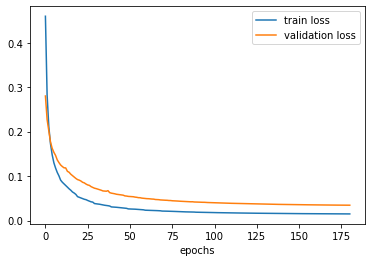

In [43]:
plt.plot(np.arange(epoch-1), train_losses[1:], label='train loss')
plt.plot(np.arange(epoch-1), val_losses[1:], label='validation loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [44]:
X_test, y_test = calculate_signature_matrix_dataset(test_data, lags=[10, 30, 60], stride=1, num_timesteps=5)

100%|█████████████████████████████████████████████████████████████████████████████| 2941/2941 [00:18<00:00, 155.98it/s]


In [45]:
X_test = torch.Tensor(X_test.transpose(0, 4, 1, 2, 3))
y_test = torch.Tensor(y_test.transpose(0, 3, 1, 2))
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=256, shuffle=False)

In [46]:
model = MSCRED(num_timesteps=5, attention=True).cuda()
model.load_state_dict(torch.load('weights/mscred_weights.pt'))

<All keys matched successfully>

In [47]:
val_outputs = []
with torch.no_grad():
    for batch_x, batch_y in val_loader:
        output = model(batch_x.cuda()).detach().cpu().numpy()
        val_outputs.append(output)
val_outputs = np.concatenate(val_outputs, axis=0)

In [48]:
y_val = y_val.numpy()

In [49]:
outputs = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        output = model(batch_x.cuda()).detach().cpu().numpy()
        outputs.append(output)
outputs = np.concatenate(outputs, axis=0)

In [50]:
y_test = y_test.cpu().numpy()

In [51]:
def calculate_mse(true, pred):
    residual_matrix = true - pred
    err = np.sum(residual_matrix**2, axis=1)
    err = np.sum(err, axis=1)
    err = np.sum(err, axis=1)/(pred.shape[1]*pred.shape[2]*pred.shape[3])
    return err, residual_matrix

In [62]:
val_mse, _ = calculate_mse(y_val, val_outputs)

mse on validation, very strange result

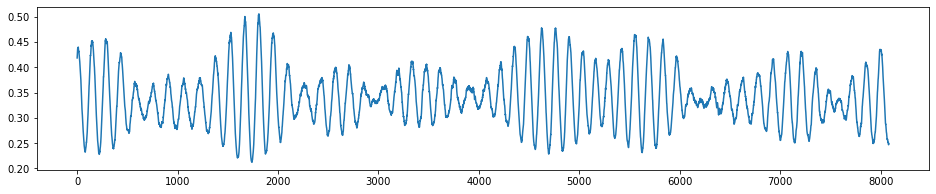

In [63]:
plt.figure(figsize=(16,3))
plt.plot(val_mse)

In [64]:
test_mse, _ = calculate_mse(y_test, outputs)

mse on test, model error doesn't show anything

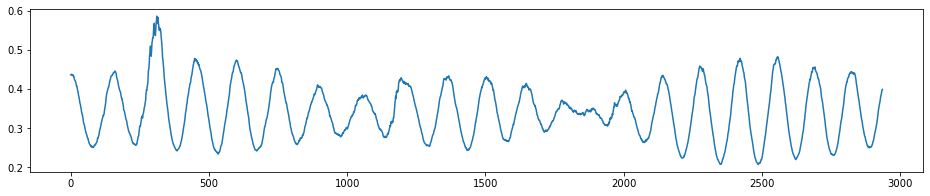

In [66]:
plt.figure(figsize=(16,3))
plt.plot(test_mse)

target matrix

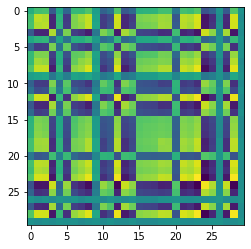

In [56]:
plt.imshow(y_test[0,1,:,:])

reconstructed matrix

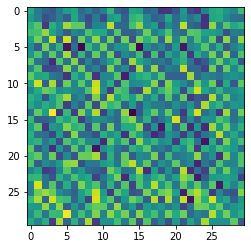

In [57]:
plt.imshow(outputs[0,1,:,:])

residual matrix / reconstruction is very poor residual matrix contains a lot of information

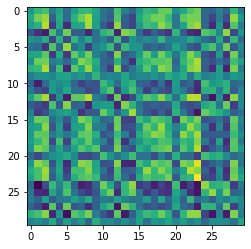

In [58]:
plt.imshow(y_test[0,1,:,:]-outputs[0,1,:,:])